In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
physical_devices = tf.test.gpu_device_name()
print(physical_devices)

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

import datasets

import numpy as np

In [2]:
def ds_preprocess_image(entity):
    img = entity["image"]
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    entity["image"] = resize
    return entity

In [3]:
def preprocess_image(img):
    width, height = img.size
    target_size = min(width, height)
    left = max(0, (width - target_size ) // 2)
    right = left + target_size
    top = max(0, (height - target_size ) // 2)
    bottom = top + target_size
    crop = img.crop((left, top, right, bottom)).convert('RGB')
    resize = crop.resize((512,512))
    return np.array(resize)

In [4]:
preprocess = False
if preprocess:

    # load image data

    ds = datasets.load_from_disk("../../data/diffusion_and_real/")

    train_images = np.array([preprocess_image(image) for image in ds["train"]["image"]])
    train_labels = np.array(ds["train"]["label"])

    vali_images = np.array([preprocess_image(image) for image in ds["vali"]["image"]])
    vali_labels = np.array(ds["vali"]["label"])

    test_images = np.array([preprocess_image(image) for image in ds["test"]["image"]])
    test_labels = np.array(ds["test"]["label"])

    ds_map = ds.map(ds_preprocess_image)

    ds_tf = ds_map.with_format("tf")

    ds_tf.save_to_disk("ds-tf")
else:
    ds_tf = datasets.load_from_disk("ds-tf-224")

In [5]:
ds_tf_train = ds_tf["train"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_vali = ds_tf["vali"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

ds_tf_test = ds_tf["test"].to_tf_dataset(
            columns=["image"],
            label_cols=["label"],
            batch_size=3,
            shuffle=True
            )

c:\Users\Tim\AppData\Local\Programs\Python\Python38\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [6]:
ds_tf_train

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(8, (5, 5), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(8, (7, 7), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(30)) #removed for now to keep the network simple and fast 
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 8)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 98568)             0         
                                                                 
 dense (Dense)               (None, 30)                2957070   
                                                                 
 dense_1 (Dense)             (None, 1)                 31        
                                                                 
Total params: 2,957,325
Trainable params: 2,957,325
Non-trainable params: 0
______________________________________________

In [8]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name, l.input_shape, l.dtype) for l in model.layers]

(None, 224, 224, 3) <dtype: 'float32'>
(None, 1) <dtype: 'float32'>
conv2d (None, 224, 224, 3) float32
max_pooling2d (None, 222, 222, 8) float32
flatten (None, 111, 111, 8) float32
dense (None, 98568) float32
dense_1 (None, 30) float32


[None, None, None, None, None]

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),  # dear god let this be the right loss function from_logits=False BinaryCrossentropy
              metrics=['accuracy'])

history = model.fit(ds_tf_train, epochs=10, batch_size = 32, max_queue_size=1, shuffle=True,
                    validation_data=ds_tf_vali
                    )

Epoch 1/10
6000/6000 [==============================] - 191s 32ms/step - loss: 60.5435 - accuracy: 0.5828 - val_loss: 0.7289 - val_accuracy: 0.5730
Epoch 2/10
6000/6000 [==============================] - 190s 32ms/step - loss: 0.6576 - accuracy: 0.6118 - val_loss: 0.7223 - val_accuracy: 0.5840
Epoch 3/10
6000/6000 [==============================] - 188s 31ms/step - loss: 0.6074 - accuracy: 0.6432 - val_loss: 0.7099 - val_accuracy: 0.6090
Epoch 4/10
6000/6000 [==============================] - 205s 34ms/step - loss: 0.5292 - accuracy: 0.6965 - val_loss: 0.7653 - val_accuracy: 0.6180
Epoch 5/10
6000/6000 [==============================] - 196s 33ms/step - loss: 0.4517 - accuracy: 0.7459 - val_loss: 1.0201 - val_accuracy: 0.6150
Epoch 6/10
6000/6000 [==============================] - 200s 33ms/step - loss: 0.3961 - accuracy: 0.7768 - val_loss: 1.0967 - val_accuracy: 0.6080
Epoch 7/10
6000/6000 [==============================] - 195s 33ms/step - loss: 0.3849 - accuracy: 0.7892 - val_loss: 

In [10]:
model.save("CNN-exp")

INFO:tensorflow:Assets written to: CNN-exp\assets


INFO:tensorflow:Assets written to: CNN-exp\assets


334/334 - 2s - loss: 2.5595 - accuracy: 0.5970 - 2s/epoch - 7ms/step


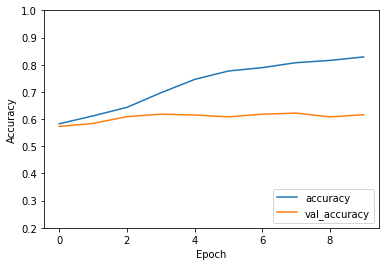

In [11]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(ds_tf_test, verbose=2)


In [12]:
print(test_acc)


0.597000002861023


In [13]:
true_label = ds_tf_test["vali"]["label"]

In [14]:
# eval test set
from tqdm import tqdm
# confusion matrix
predictions = []
res = model.predict(ds_tf_test, batch_size=10)
predictions = [1 if pred > 0.5 else 0 for pred in res]

334/334 [==============================] - 3s 8ms/step


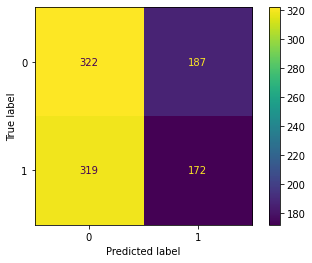

{'0': {'precision': 0.5023400936037441,
  'recall': 0.6326129666011788,
  'f1-score': 0.5599999999999999,
  'support': 509},
 '1': {'precision': 0.479108635097493,
  'recall': 0.35030549898167007,
  'f1-score': 0.40470588235294114,
  'support': 491},
 'accuracy': 0.494,
 'macro avg': {'precision': 0.49072436435061856,
  'recall': 0.49145923279142445,
  'f1-score': 0.48235294117647054,
  'support': 1000},
 'weighted avg': {'precision': 0.4909334474771748,
  'recall': 0.494,
  'f1-score': 0.48375058823529404,
  'support': 1000}}

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


cm = confusion_matrix(true_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()
classification_report(true_label, predictions, output_dict=True)


In [17]:
ds_tf_vali

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
model.evaluate(ds_tf_vali, verbose=2)

334/334 - 2s - loss: 2.3816 - accuracy: 0.6160 - 2s/epoch - 7ms/step


[2.381618022918701, 0.6159999966621399]

In [19]:
res = model.predict(ds_tf_vali)

334/334 [==============================] - 3s 7ms/step


In [20]:
res

array([[2.33461093e-02],
       [4.58383769e-01],
       [5.72657228e-01],
       [1.19374752e-01],
       [4.03998494e-01],
       [5.49387515e-01],
       [4.58383769e-01],
       [4.58383769e-01],
       [3.37345555e-04],
       [8.09768153e-06],
       [7.14595973e-01],
       [4.58383769e-01],
       [1.00000000e+00],
       [4.58383769e-01],
       [0.00000000e+00],
       [4.58383769e-01],
       [2.08738912e-03],
       [5.78648105e-05],
       [8.75258625e-01],
       [1.00000000e+00],
       [4.50660139e-01],
       [9.66763914e-01],
       [3.01567197e-01],
       [1.77875227e-05],
       [4.58383769e-01],
       [3.98419201e-01],
       [1.00000000e+00],
       [2.35066771e-35],
       [4.58383769e-01],
       [9.99970675e-01],
       [5.20229459e-01],
       [4.58383769e-01],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.98992741e-01],
       [7.85110705e-03],
       [9.99988616e-01],
       [1.00000000e+00],
       [6.55825436e-02],
       [4.58383769e-01],


In [21]:
res_2 = model.predict(ds_tf["test"]["image"])
res_2

32/32 [==============================] - 1s 39ms/step


array([[4.58383769e-01],
       [4.58383769e-01],
       [9.35809553e-01],
       [3.44589114e-01],
       [8.55417252e-02],
       [1.96909294e-01],
       [9.89357710e-01],
       [6.25258148e-01],
       [4.58383769e-01],
       [4.58383769e-01],
       [9.99998510e-01],
       [4.58383769e-01],
       [4.58383769e-01],
       [9.76883678e-12],
       [4.87168372e-01],
       [1.78325458e-18],
       [9.96059120e-01],
       [5.19522727e-01],
       [1.00000000e+00],
       [9.17718649e-01],
       [4.58383769e-01],
       [4.64636236e-01],
       [2.70040880e-04],
       [1.17220543e-05],
       [4.58383769e-01],
       [4.58383769e-01],
       [1.72676309e-03],
       [4.58383769e-01],
       [4.61331129e-01],
       [4.64637727e-01],
       [2.97354758e-01],
       [2.91419715e-01],
       [4.58383769e-01],
       [4.58979368e-01],
       [1.06479675e-01],
       [4.58383769e-01],
       [4.58383769e-01],
       [1.00000000e+00],
       [2.56838381e-01],
       [8.11127543e-01],
